In [1]:

import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q = '''SELECT p.* FROM ebmdatalab.outlier_detection.chem_by_subpara_by_ccg_juntoaug17_limitsubpara p
-- exclude non-standard CCG codes:
INNER JOIN ebmdatalab.hscic.ccgs c ON p.pct = c.code AND c.org_type = "CCG"
'''

df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard')
# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)

q2 = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard')

q3 = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q3, GBQ_PROJECT_ID, dialect='standard')

df1.head()

,pct,chemical,subpara,num,denom,ratio
0,00C,0101010C0,0101010,4,217,0.018433
1,00C,0101010G0,0101010,198,217,0.912442
2,00C,0101010L0,0101010,1,217,0.004608
3,00C,0101010R0,0101010,14,217,0.064516
4,00D,0101010G0,0101010,553,637,0.868132


## Clean the data: sort out null denominators

In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph,, even if not prescribed.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all ccgs
b = df1[["pct"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - this will list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","subpara","chemical"])  # 237,636 rows
data


# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","subpara","denom"]].groupby(["subpara","pct"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct"], suffixes=("_subpara",""))
# check how many have zero denominators:
# data.loc[(data["denom_subpara"]==0)] # 19,665 rows 

# exclude combinations where denominators are zero THEN replace NAs with 0:
data2 = d2.loc[(d2["denom_subpara"]!=0)]
data2 = data2.fillna(0)
data2.head()


,pct,subpara,denom_subpara,chemical,num,denom,ratio
0,00C,0101010,217.0,0101010C0,4.0,217.0,0.018433
1,00C,0101010,217.0,0101010G0,198.0,217.0,0.912442
2,00C,0101010,217.0,0101010L0,1.0,217.0,0.004608
3,00C,0101010,217.0,0101010R0,14.0,217.0,0.064516
4,00C,0101010,217.0,0101010J0,0.0,0.0,0.000000


### Filter out low numbers (chemical and subpara)

In [3]:
# total prescribing for each chemical
# sum numerators to find total volume for each chemical across all ccgs
num = pd.DataFrame(df1["num"].groupby(df1["chemical"]).sum()).reset_index()

# calculate centile for numerator for each ccg
num["num centile"] = pd.qcut(num["num"], 10, labels=np.arange(1,11,1))

# total prescribing for each paragraph
d3 = d2[["pct","subpara","denom_subpara"]].drop_duplicates()
d3 = d3.groupby("subpara").sum().sort_values(by="denom_subpara")
d3["denom centile"] = pd.qcut(d3["denom_subpara"], 10, labels=np.arange(1,11,1))
d3 = d3.reset_index()


# merge with data table
data3 = data2.merge(num, how="inner", on="chemical",suffixes=("","_total"))
data3 = data3.merge(d3, how="inner", on="subpara",suffixes=("","_total"))

# filter out CCGs with lowest denominator values
data3 = data3.loc[(data3["denom centile"]>2)]

# num of CCGs prescribing each chemical
count_ = pd.DataFrame(data3.loc[data3["num"]>0].groupby("chemical")["pct"].nunique()).reset_index()
count_ = count_.rename(columns={"pct":"count2"})

data3 = data3.merge(count_, how="inner", on="chemical")

data3.head()

,pct,subpara,denom_subpara,chemical,num,denom,ratio,num_total,num centile,denom_subpara_total,denom centile,count2
0,00C,0101010,217.0,0101010C0,4.0,217.0,0.018433,1423,5,39497.0,4,125
1,00D,0101010,637.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125
2,00J,0101010,520.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125
3,00K,0101010,321.0,0101010C0,16.0,321.0,0.049844,1423,5,39497.0,4,125
4,00L,0101010,322.0,0101010C0,0.0,0.0,0.000000,1423,5,39497.0,4,125


## Calculate key stats
### Median, Range, SD, Kurtosis and Skew

In [4]:
#select columns of interest and get key stats
df2 = pd.DataFrame(data3.groupby(["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count2"])["ratio"].describe())
#df2 = df2.unstack()
#df2.columns = df2.columns.droplevel()

df3 = df2.reset_index()
df3["range"] = df3["max"] - df3["min"]
df3 = df3[["chemical","subpara","num_total","num centile","denom_subpara_total","denom centile","count","count2","50%","min","max","range","std"]].rename(columns={"50%":"median"})

# filter out chemicals in paragraphs only prescribed by few CCGs
df3 = df3.loc[df3["count"]>=50]


# reshape data to put CCGs in columns
df5 = data3.pivot(index="chemical",columns='pct', values='ratio')

#calculate kurtosis and skew for each chemical
import scipy.stats as stats
k = pd.Series(stats.kurtosis(df5, axis=1,nan_policy="omit"),name="kurtosis")
sk =  pd.Series(stats.skew(df5, axis=1,nan_policy="omit"),name="skew")

# compile all stats together
result = pd.concat([df3, k, sk], axis=1).sort_values(by="kurtosis",ascending=False)
result = result[["chemical","subpara", "count","count2","num_total","num centile","median","min","max","range","std","kurtosis","skew"]].round(2)

# Lookup chemical and subparagraph names
df4 = result.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
df4 = df4.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
df4 = df4[["chemical","chemical name","subpara","subpara name","num_total","num centile", "count","count2","median","min","max","range", "std","kurtosis","skew"]].round(2)

df4.head()

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew
0,0501012G0,Flucloxacillin Sodium,0501012,Penicillinase-Resistant Penicillins,1058061.0,10,207.0,207.0,1.0,1.0,1.00,0.00,0.0,202.0,-14.28
1,0304010F0,Brompheniramine Maleate,0304010,Antihistamines,8.0,1,207.0,1.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
2,020400010,Pindolol With Diuretic,0204000,Beta-Adrenoceptor Blocking Drugs,1.0,1,207.0,1.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28
3,120203000,Other Nasal Infection Preps,1202030,Nasal Prepn for Infection,2.0,1,207.0,1.0,0.0,0.0,0.01,0.01,0.0,202.0,14.28
4,1001030A0,Auranofin,1001030,Rheumatic Disease Suppressant Drugs,1.0,1,207.0,1.0,0.0,0.0,0.00,0.00,0.0,202.0,14.28


## Ranking Chemicals by Range, Kurtosis, Skew and SD
Those with high SD tend to be chemicals where there is general disagreement, so outliers are not *that* unusual

In [5]:
# limit to those with positive skew, i.e. most CCGs prescribe few and those prescribing more are ouliers,
# and range at least 10%:

dfp = df4.loc[(df4["skew"]>=0) & (df4["range"]>0.1)]

# sort by range
r1 = dfp.sort_values(by=["range","kurtosis"],ascending=False)
# create a ranking
r1["R"]  = r1["range"].rank(ascending=False, method="min")

# sort by kurtosis 
r2 = dfp.sort_values(by=["kurtosis"],ascending=False)
r2["K"] = r2["kurtosis"].rank(ascending=False, method="min")

# sort by skew
r3 = dfp.sort_values(by=["skew"],ascending=False)
r3["Sk"] = r3["skew"].rank(ascending=False, method="min")

r1 = dfp.copy()
# create a ranking
r1["R"] = r1["range"].rank(ascending=False, method="min")
r1["K"] = r1["kurtosis"].rank(ascending=False, method="min")
r1["Sk"] = r1["skew"].rank(ascending=False, method="min")


r1.sort_values(by="K").head(20)

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.00,0.0,0.68,0.68,0.05,157.67,12.36,50.0,1.0,1.0
94,090602700,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,307.0,2.0,2.0
114,0601021X0,Tolbutamide,0601021,Sulfonylureas,7666.0,6,207.0,187.0,0.00,0.0,0.12,0.12,0.01,110.49,9.49,375.0,3.0,3.0
155,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,354.0,4.0,4.0
177,0902011L0,Calcium Polystyrene Sulfonate,0902011,Oral Potassium,561.0,4,192.0,118.0,0.01,0.0,0.43,0.43,0.04,74.50,7.47,132.0,5.0,7.0
180,0501021B0,Cefadroxil,0501021,Cephalosporins,1107.0,4,207.0,96.0,0.00,0.0,0.25,0.25,0.02,71.29,7.41,236.0,6.0,8.0
192,0101010F0,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.00,0.0,0.19,0.19,0.02,66.74,7.53,293.0,7.0,6.0
196,0504010L0,Mefloquine Hydrochloride,0504010,Antimalarials,4625.0,5,207.0,89.0,0.00,0.0,0.32,0.32,0.04,64.92,8.15,191.0,8.0,5.0
205,0501120X0,Levofloxacin,0501120,Quinolones,4637.0,6,207.0,201.0,0.02,0.0,0.37,0.37,0.03,61.48,6.32,161.0,9.0,13.0
222,0905013N0,Magnesium Sulfate,0905013,Magnesium,108.0,3,156.0,33.0,0.00,0.0,0.21,0.21,0.02,55.03,6.61,278.0,10.0,12.0


### Add hyperlinks to maps

In [6]:
# assign overall scores based on all three rankings

r2 = r1.copy()
columns = ["R","K","Sk"]
r2['score'] = 0
for col in columns:
    r2.loc[r2[col]<=10, 'score'] = r2['score']+10 # if in top 10, score 10
    r2.loc[(r2[col]>10)&(r2[col]<=50), 'score'] = r2['score']+5 # if in top 10, score 10
rc = r2.sort_values(by=["score","kurtosis"],ascending=False)
rc.head()

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk,score
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622.0,4,189.0,25.0,0.00,0.0,0.68,0.68,0.05,157.67,12.36,50.0,1.0,1.0,25
94,090602700,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,307.0,2.0,2.0,20
114,0601021X0,Tolbutamide,0601021,Sulfonylureas,7666.0,6,207.0,187.0,0.00,0.0,0.12,0.12,0.01,110.49,9.49,375.0,3.0,3.0,20
155,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,354.0,4.0,4.0,20
177,0902011L0,Calcium Polystyrene Sulfonate,0902011,Oral Potassium,561.0,4,192.0,118.0,0.01,0.0,0.43,0.43,0.04,74.50,7.47,132.0,5.0,7.0,20


note: links go to up-to-date maps and can only show chemical/para not subpara. 

In [7]:

links = rc.copy().head(50)
links["str"] = links["subpara"].str[0:2].map(int).map(str)+"."+links["subpara"].str[2:4].map(int).map(str)+"."+links["subpara"].str[4:6].map(int).map(str)
links["link"] = "https://openprescribing.net/analyse/#org=CCG&numIds="+links["chemical"]+"&denomIds="+links["str"]+"&selectedTab=map"
links = links.drop("str",axis=1)

def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

links = pd.DataFrame(links).style.format(make_clickable, subset=['link'])
links

,chemical,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,R,K,Sk,score,link
70,1310011AA,Retapamulin,1310011,Antibacterial Preps Only Used Topically,622,4,189,25,0,0,0.68,0.68,0.05,157.67,12.36,50,1,1,25,https://openprescribing.net/analyse/#org=CCG&numIds=1310011AA&denomIds=13.10.1&selectedTab=map
94,090602700,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070,4,207,116,0,0,0.17,0.17,0.01,126.43,10.67,307,2,2,20,https://openprescribing.net/analyse/#org=CCG&numIds=090602700&denomIds=9.6.2&selectedTab=map
114,0601021X0,Tolbutamide,0601021,Sulfonylureas,7666,6,207,187,0,0,0.12,0.12,0.01,110.49,9.49,375,3,3,20,https://openprescribing.net/analyse/#org=CCG&numIds=0601021X0&denomIds=6.1.2&selectedTab=map
155,0206040AF,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70,3,185,24,0,0,0.13,0.13,0.01,88.27,8.85,354,4,4,20,https://openprescribing.net/analyse/#org=CCG&numIds=0206040AF&denomIds=2.6.4&selectedTab=map
177,0902011L0,Calcium Polystyrene Sulfonate,0902011,Oral Potassium,561,4,192,118,0.01,0,0.43,0.43,0.04,74.5,7.47,132,5,7,20,https://openprescribing.net/analyse/#org=CCG&numIds=0902011L0&denomIds=9.2.1&selectedTab=map
180,0501021B0,Cefadroxil,0501021,Cephalosporins,1107,4,207,96,0,0,0.25,0.25,0.02,71.29,7.41,236,6,8,20,https://openprescribing.net/analyse/#org=CCG&numIds=0501021B0&denomIds=5.1.2&selectedTab=map
192,0101010F0,Magnesium Carbonate,0101010,Antacids and Simeticone,119,3,192,25,0,0,0.19,0.19,0.02,66.74,7.53,293,7,6,20,https://openprescribing.net/analyse/#org=CCG&numIds=0101010F0&denomIds=1.1.1&selectedTab=map
196,0504010L0,Mefloquine Hydrochloride,0504010,Antimalarials,4625,5,207,89,0,0,0.32,0.32,0.04,64.92,8.15,191,8,5,20,https://openprescribing.net/analyse/#org=CCG&numIds=0504010L0&denomIds=5.4.1&selectedTab=map
205,0501120X0,Levofloxacin,0501120,Quinolones,4637,6,207,201,0.02,0,0.37,0.37,0.03,61.48,6.32,161,9,13,15,https://openprescribing.net/analyse/#org=CCG&numIds=0501120X0&denomIds=5.1.12&selectedTab=map
222,0905013N0,Magnesium Sulfate,0905013,Magnesium,108,3,156,33,0,0,0.21,0.21,0.02,55.03,6.61,278,10,12,15,https://openprescribing.net/analyse/#org=CCG&numIds=0905013N0&denomIds=9.5.1&selectedTab=map


### Histograms

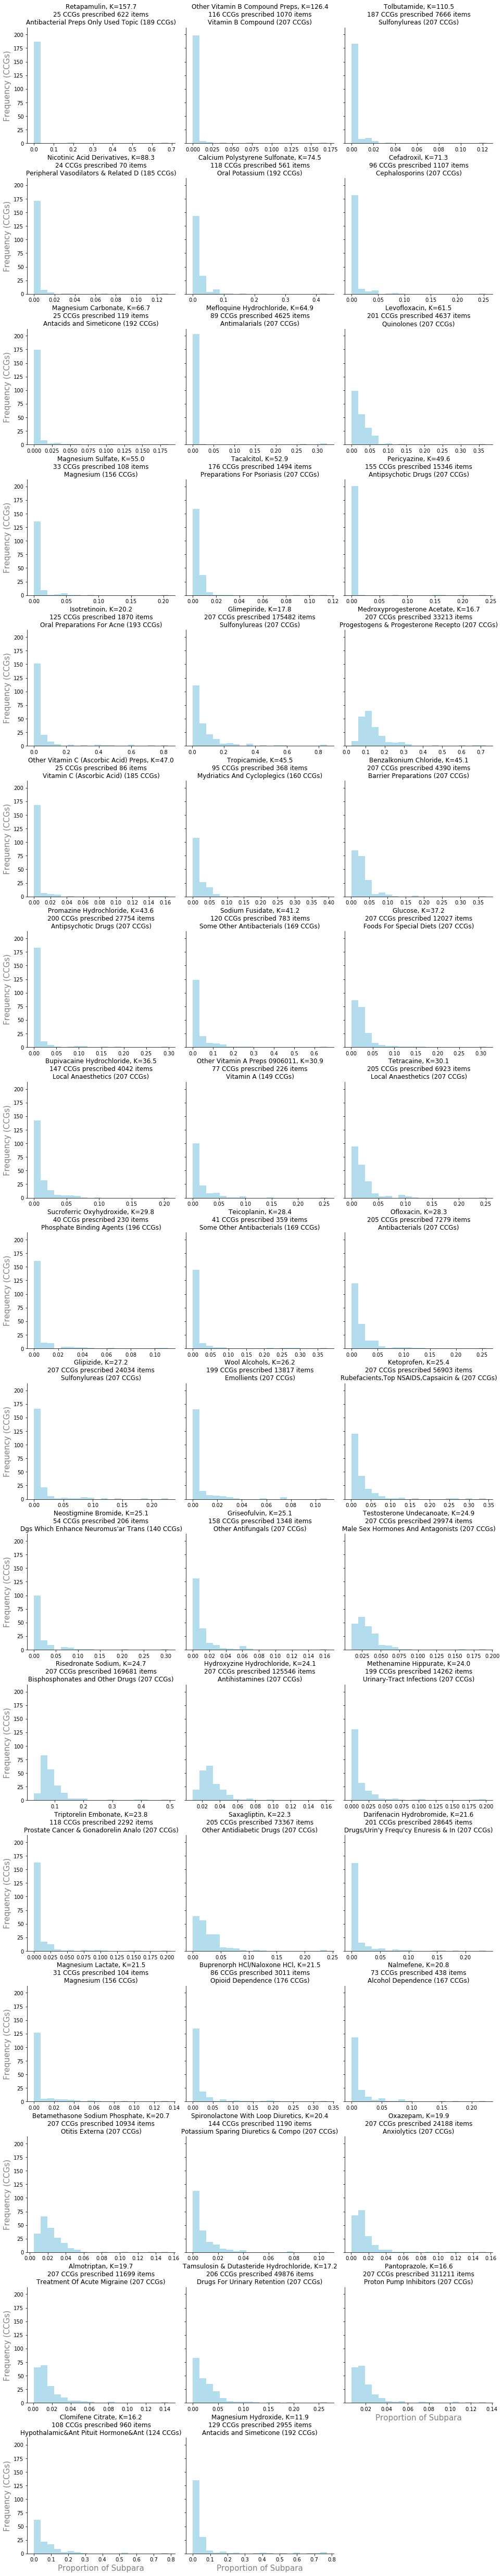

In [8]:
# plot top 50 only
## exclude practice IDs etc and select only lists of figures to plot:
dfh = rc[["chemical","chemical name","subpara name","count","count2","score","kurtosis","num_total"]].head(50).merge(data3[["chemical","ratio"]], on="chemical").drop("chemical",axis=1)#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical name","subpara name","kurtosis","count","count2","num_total"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical name"]+", K="+titles["kurtosis"].round(1).map(str)+"\n"+titles["count2"].map(int).map(str)+" CCGs prescribed "+titles["num_total"].map(int).map(str)+" items\n"+titles["subpara name"].str[0:35]+" ("+titles["count"].map(int).map(str)+" CCGs)"

titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()

## Ranking chemicals by percentile differences / IQR etc.
First Calculate various percentiles

In [9]:
dftest = df5.transpose()
q = [0.03,0.05,0.25,0.5,0.75,0.95,0.97]

# calculate modal value for each chemical
# note where there are multiple modal values, all are given so we take max here
mo = pd.DataFrame(dftest.mode(numeric_only=True).max()).reset_index()
mo = mo.rename(columns={0:"mode"})

smy0 = dftest.describe(percentiles=q).drop(["count","mean","std"]).transpose().reset_index()

#calculate IQR
smy0["IQR"] = smy0["75%"]-smy0["25%"] 
smy0 = smy0.merge(mo, on="chemical", how="left")

smy0.head()


,chemical,min,3%,5%,25%,50%,75%,95%,97%,max,IQR,mode
0,0101010C0,0.000000,0.000000,0.00000,0.000000,0.013179,0.058570,0.193023,0.219687,0.340426,0.058570,0.0
1,0101010F0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.019306,0.033701,0.185629,0.000000,0.0
2,0101010G0,0.081081,0.149077,0.16075,0.333333,0.440633,0.590946,0.792278,0.820035,0.912442,0.257613,0.5
3,0101010I0,0.000000,0.000000,0.00000,0.000000,0.016001,0.042445,0.125394,0.159254,0.294872,0.042445,0.0
4,0101010J0,0.000000,0.000000,0.00000,0.008860,0.018857,0.037184,0.080607,0.109442,0.162162,0.028325,0.0


### Chemicals with largest ratio of 95-97th percentiles to 50-95th percentiles and with mode = 0
A large difference between the top-prescribing CCGs and the mid-high prescribing CCGs will indicate that there are several CCGs prescribing well above average levels.

In [10]:
smy2 = smy0.copy()
smy2["95-97"] = smy2["97%"]-smy2["95%"]
smy2["50-95"] = smy2["95%"]-smy2["50%"]
smy2["ratio2"] = smy2["95-97"]/smy2["50-95"]

# limit to those where mode is zero
smy2 = smy2.loc[smy2["mode"]==0]

smy2 = smy2.reset_index()
smy2 = smy2[["chemical","ratio2","25%"]].merge(dfp, on="chemical")
smy2["M2"]  = smy2["ratio2"].rank(ascending=False, method="min")

smy2.sort_values(by="ratio2",ascending=False).head(10)


,chemical,ratio2,25%,chemical name,subpara,subpara name,num_total,num centile,count,count2,median,min,max,range,std,kurtosis,skew,M2
28,0402010S0,1.804282,0.000615,Promazine Hydrochloride,0402010,Antipsychotic Drugs,27754.0,7,207.0,200.0,0.00,0.0,0.30,0.30,0.03,43.61,6.07,1.0
27,0402010P0,0.880253,0.000021,Pericyazine,0402010,Antipsychotic Drugs,15346.0,7,207.0,155.0,0.00,0.0,0.24,0.24,0.03,49.60,6.99,2.0
75,090602700,0.871552,0.000000,Other Vitamin B Compound Preps,0906027,Vitamin B Compound,1070.0,4,207.0,116.0,0.00,0.0,0.17,0.17,0.01,126.43,10.67,3.0
89,1306020J0,0.829108,0.000000,Isotretinoin,1306020,Oral Preparations For Acne,1870.0,5,193.0,125.0,0.01,0.0,0.83,0.83,0.12,20.18,4.33,4.0
1,0101010F0,0.745605,0.000000,Magnesium Carbonate,0101010,Antacids and Simeticone,119.0,3,192.0,25.0,0.00,0.0,0.19,0.19,0.02,66.74,7.53,5.0
17,0206040AF,0.736185,0.000000,Nicotinic Acid Derivatives,0206040,Peripheral Vasodilators & Related Drugs,70.0,3,185.0,24.0,0.00,0.0,0.13,0.13,0.01,88.27,8.85,6.0
23,0301040R0,0.705329,0.013825,Salbutamol,0301040,Compound Bronchodilator Preparations,5928.0,6,205.0,202.0,0.03,0.0,0.36,0.36,0.05,14.29,3.45,7.0
79,1103010Y0,0.646969,0.005052,Ofloxacin,1103010,Antibacterials,7279.0,6,207.0,205.0,0.01,0.0,0.26,0.26,0.03,28.26,4.39,8.0
61,0803042R0,0.628028,0.000000,Degarelix,0803042,Prostate Cancer & Gonadorelin Analogues,3523.0,5,207.0,136.0,0.00,0.0,0.20,0.20,0.04,10.96,3.36,9.0
13,0203020R0,0.616192,0.010339,Propafenone Hydrochloride,0203020,Drugs For Arrhythmias,5295.0,6,207.0,203.0,0.02,0.0,0.11,0.11,0.02,7.44,2.33,10.0


### Histograms for top chemicals by percentile ratio (95-97th:50-95th) and with mode = 0

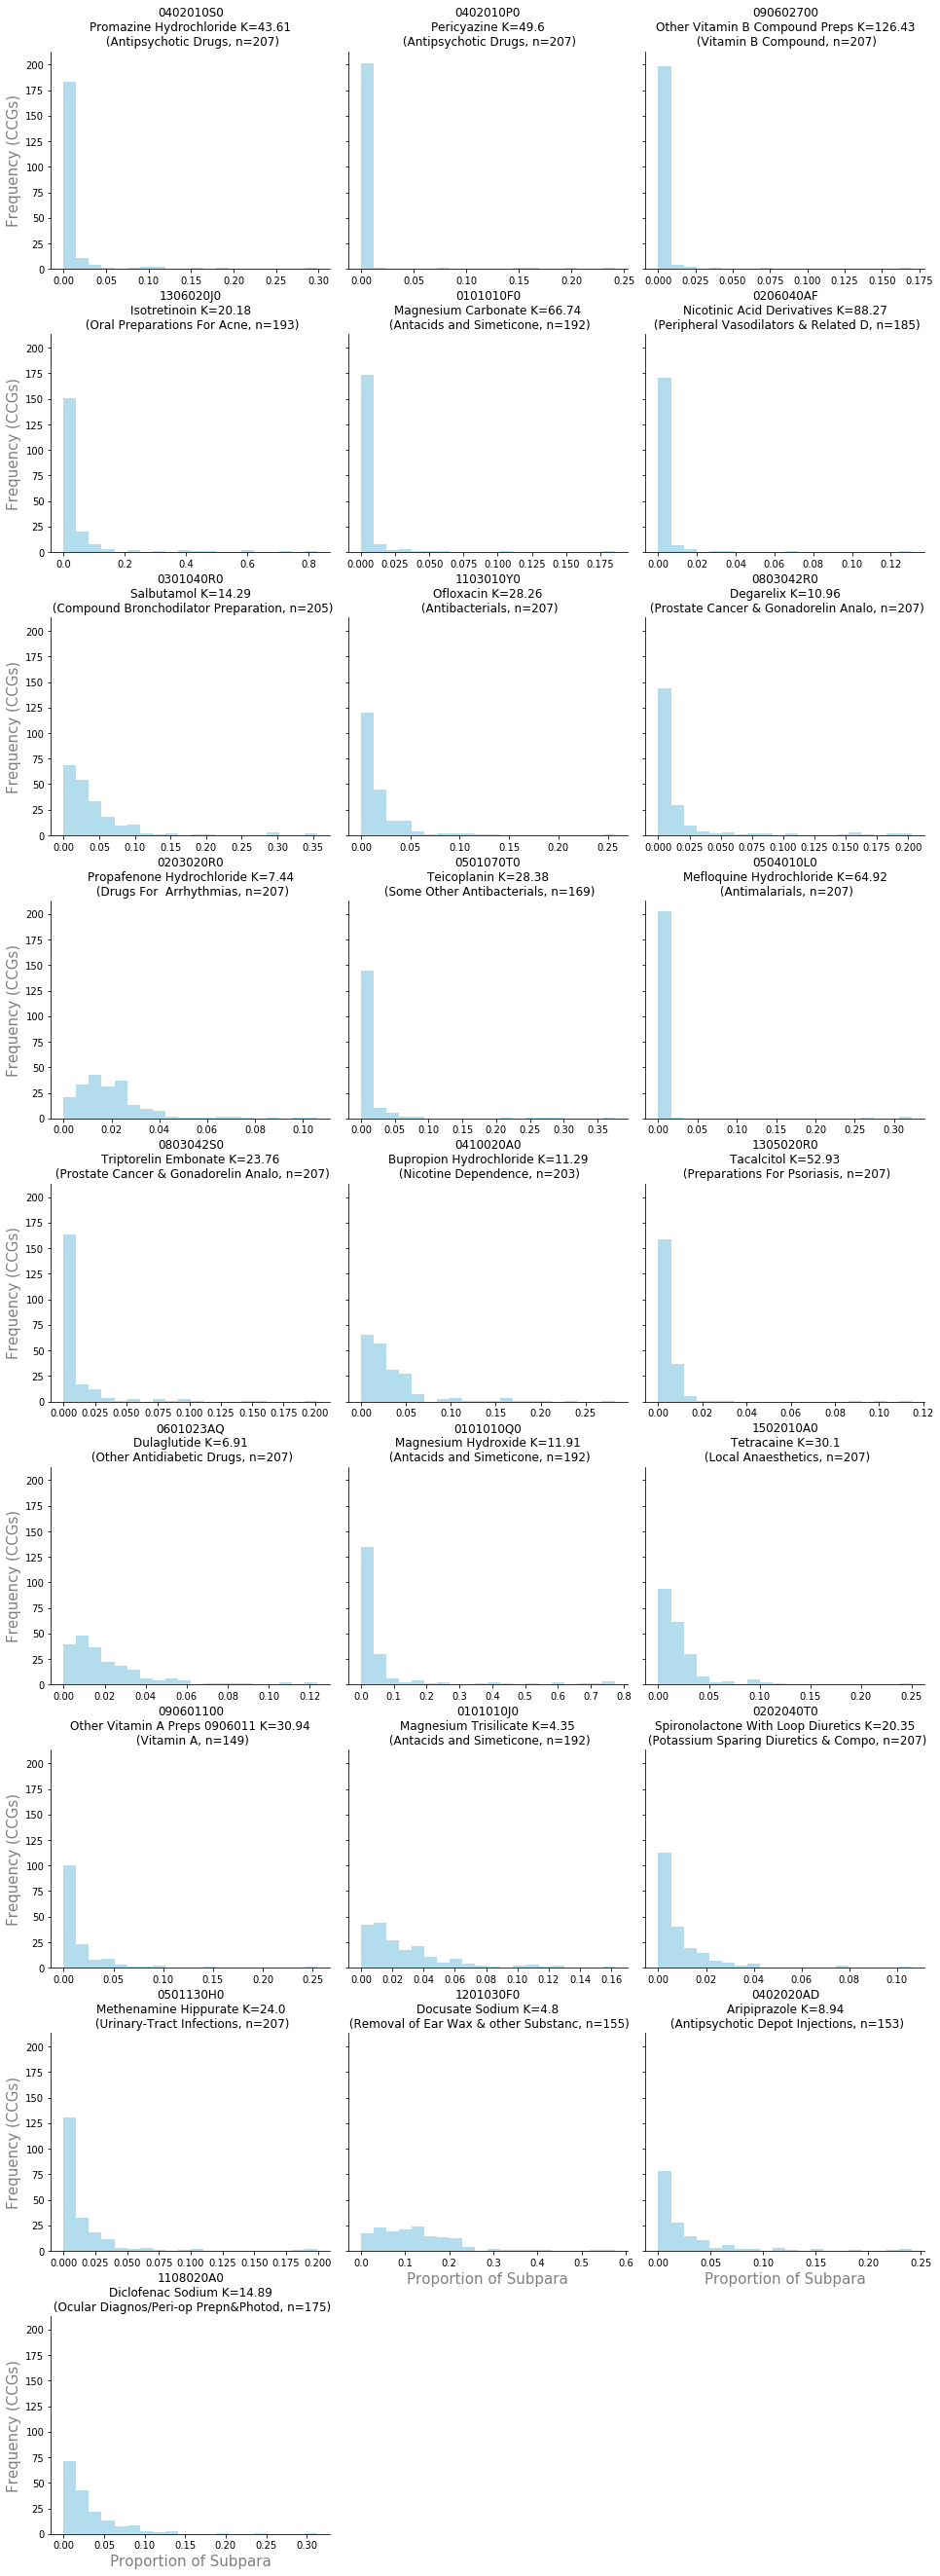

In [11]:
## exclude practice IDs etc and select only lists of figures to plot:
dfh = smy2.sort_values(by="ratio2",ascending=False).head(25)
dfh = dfh[["chemical","chemical name","subpara name","kurtosis","ratio2"]].merge(data3[["chemical","ratio"]], on="chemical")#.sort_values(by="chemical name")

# create list of titles for charts - combine chem name with para name and no of CCGs prescribing each 
titles = dfh.groupby(["chemical","chemical name","subpara name","kurtosis","ratio2"]).count().reset_index().rename(columns={"ratio":"n"})
titles["title"] = titles["chemical"]+"\n"+ titles["chemical name"]+" K="+titles["kurtosis"].map(str)+"\n ("+titles["subpara name"].str[0:35]+", n="+titles["n"].map(str) +")"
titles = dfh[["chemical name"]].drop_duplicates().merge(titles,on="chemical name")
titles = titles["title"]



import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap # this will interpret "\n" as newline

## use facetgrid to create a grid of charts. 
# "chemical name" column is used to split data across charts. 
#### note it's also possible to set hue="columnname" to show multiple data groupings on one chart split by colour. 
g = sns.FacetGrid(dfh, col="chemical name",col_wrap=3,sharey=True,sharex=False,size=5)

## define histograms to plot:
g.map(sns.distplot, "ratio", kde=False, bins=20, hist_kws={"color": '#81c5e2', "alpha": .6}) 
g.set_ylabels("Frequency (CCGs)", size=15, alpha=0.5)
g.set_xlabels("Proportion of Subpara", size=15, alpha=0.5)

## Set the ticklabel size and color:
#loop through each plot
for ax,title in zip(g.axes.flat,titles):
    ax.tick_params(labelsize=10,labelcolor="black")
    
## Set the size of titles:
g.set_titles(size = 22)

## Set the titles
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

## adjust spacing of sub plots:
plt.subplots_adjust(left=0.15, top=0.8, hspace = 0.3)

plt.show()